In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import randint
import numpy as np

# Function to load and preprocess data
def load_and_preprocess_data(filepath):
    df = pd.read_csv(r"C:\Users\jacob\Desktop\nbaallelo\Capstone_NBA_Predict\nbaallelo.csv")
    encoder = LabelEncoder()
    categorical_features = ['game_location', 'game_result']
    for feature in categorical_features:
        df[feature] = encoder.fit_transform(df[feature])
    df['avg_pts'] = df.groupby('team_id')['pts'].transform(lambda x: x.expanding().mean())
    return df

# Function for feature selection and data split
def prepare_data(df, feature_columns, target_column, test_size=0.2, random_state=42):
    X = df[feature_columns]
    y = df[target_column]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Function to train and evaluate model
def train_and_evaluate_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Model Accuracy: {accuracy}")
    return model

# Function for parameter optimization
def optimize_parameters(X, y, model, param_dist, n_iter=50, cv=5, random_state=42):
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=n_iter, cv=cv, scoring='accuracy', random_state=random_state, n_jobs=-1, verbose=2)
    random_search.fit(X, y)
    print("Best parameters found: ", random_search.best_params_)
    return random_search.best_estimator_

# Main workflow
if __name__ == "__main__":
    filepath = r"C:\Users\jacob\Desktop\nbaallelo\Capstone_NBA_Predict\nbaallelo.csv"
    df = load_and_preprocess_data(filepath)
    feature_columns = ['elo_i', 'opp_elo_i', 'game_location', 'avg_pts', 'seasongame']
    target_column = 'game_result'
    X_train, X_test, y_train, y_test = prepare_data(df, feature_columns, target_column)

    # Train and evaluate RandomForestClassifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    train_and_evaluate_model(X_train, X_test, y_train, y_test, rf_model)

    # Parameter optimization for RandomForestClassifier
    param_dist_rf = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 20),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 20),
        'max_features': ['sqrt', 'log2', None]
    }
    optimized_rf_model = optimize_parameters(X_train, y_train, rf_model, param_dist_rf)

    # Train and evaluate ExtraTreesClassifier
    et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
    train_and_evaluate_model(X_train, X_test, y_train, y_test, et_model)

    # Cross-validation for ExtraTreesClassifier
    scores = cross_val_score(et_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    print(f"Accuracy for each fold: {scores}")
    print(f"Mean cross-validation accuracy: {np.mean(scores)}")
    print(f"Standard deviation of cross-validation accuracy: {np.std(scores)}")


Model Accuracy: 0.6572061908720263
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 366}
Model Accuracy: 0.6588687012627162
Accuracy for each fold: [0.65627629 0.66145473 0.65868382 0.65957447 0.65903018]
Mean cross-validation accuracy: 0.659003896325728
Standard deviation of cross-validation accuracy: 0.0016658401856852127


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import randint
import numpy as np

# Function to load and preprocess data with additional feature engineering
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    encoder = LabelEncoder()
    
    # Encoding categorical features
    df['game_result'] = encoder.fit_transform(df['game_result'])
    df['game_location'] = encoder.fit_transform(df['game_location'])
    
    # Feature Engineering (Avoiding future data)
    df['elo_diff'] = df['elo_i'] - df['opp_elo_i']
    df['date_game'] = pd.to_datetime(df['date_game'])
    df.sort_values('date_game', inplace=True)
    
    # Creating average points feature without lookahead bias
    df['avg_pts'] = df.groupby('team_id')['pts'].transform(lambda x: x.expanding().mean())
    
    return df

# Temporal Train-Test Split
def temporal_train_test_split(df, test_size=0.2):
    split_idx = int(len(df) * (1 - test_size))
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]
    
    return train_df, test_df

# Main Workflow
if __name__ == "__main__":
    filepath = r"C:\Users\jacob\Desktop\nbaallelo\Capstone_NBA_Predict\nbaallelo.csv"
    df = load_and_preprocess_data(filepath)
    
    # Temporal train-test split to avoid future data leakage
    train_df, test_df = temporal_train_test_split(df)
    
    # Features and target variable
    feature_columns = ['elo_i', 'opp_elo_i', 'game_location', 'elo_diff', 'avg_pts','seasongame','is_playoffs']  # Revised feature list
    target_column = 'game_result'
    
    X_train = train_df[feature_columns]
    X_test = test_df[feature_columns]
    y_train = train_df[target_column]
    y_test = test_df[target_column]
    
    # Train and evaluate RandomForestClassifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_predictions)
    print(f"RandomForestClassifier Accuracy: {rf_accuracy}")
    
    # ExtraTreesClassifier (Example)
    et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
    et_model.fit(X_train, y_train)
    et_predictions = et_model.predict(X_test)
    et_accuracy = accuracy_score(y_test, et_predictions)
    print(f"ExtraTreesClassifier Accuracy: {et_accuracy}")



RandomForestClassifier Accuracy: 0.6541186715750307
ExtraTreesClassifier Accuracy: 0.6500019791790366


In [6]:
import xgboost as xgb

# Function to train and evaluate an XGBoost model
def train_and_evaluate_xgboost(X_train, X_test, y_train, y_test):
    # Convert the datasets into DMatrix objects, which is optimized for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Define the XGBoost model parameters
    params = {
        'max_depth': 6,  # Maximum depth of a tree
        'eta': 0.3,  # The learning rate
        'objective': 'binary:logistic',  # Binary classification
        'eval_metric': 'logloss',  # Evaluation metric
    }
    num_boost_round = 100  # Number of boosting rounds
    
    # Train the model
    bst = xgb.train(params, dtrain, num_boost_round, evals=[(dtest, "Test")], early_stopping_rounds=10)
    
    # Predict and evaluate the model
    y_pred_proba = bst.predict(dtest)
    y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_proba]
    accuracy = accuracy_score(y_test, y_pred)
    print(f"XGBoost Model Accuracy: {accuracy}")

# Main Workflow Continuation
if __name__ == "__main__":
   
    
    # Temporal train-test split to avoid future data leakage
    train_df, test_df = temporal_train_test_split(df)
    
    # Select features and target
    feature_columns = ['elo_i', 'opp_elo_i', 'game_location', 'elo_diff', 'avg_pts','seasongame','is_playoffs']
    target_column = 'game_result'
    
    X_train = train_df[feature_columns]
    X_test = test_df[feature_columns]
    y_train = train_df[target_column]
    y_test = test_df[target_column]
    
    # Train and evaluate XGBoost model
    train_and_evaluate_xgboost(X_train, X_test, y_train, y_test)


[0]	Test-logloss:0.64694
[1]	Test-logloss:0.62371
[2]	Test-logloss:0.61224
[3]	Test-logloss:0.60601
[4]	Test-logloss:0.60292
[5]	Test-logloss:0.60142
[6]	Test-logloss:0.60073
[7]	Test-logloss:0.60068
[8]	Test-logloss:0.60055
[9]	Test-logloss:0.60087
[10]	Test-logloss:0.60104
[11]	Test-logloss:0.60095
[12]	Test-logloss:0.60098
[13]	Test-logloss:0.60095
[14]	Test-logloss:0.60117
[15]	Test-logloss:0.60131
[16]	Test-logloss:0.60132
[17]	Test-logloss:0.60131
XGBoost Model Accuracy: 0.6709812769663144


In [7]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define the parameter grid to search
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4],
    'eta': [0.3, 0.2, 0.1, 0.05, 0.01],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=3, verbose=2, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best model
best_xgb_model = random_search.best_estimator_

# Predict and evaluate
y_pred = best_xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Improved XGBoost Model Accuracy: {accuracy}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Improved XGBoost Model Accuracy: 0.668408344218818


In [8]:
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame and you've already processed it as shown before
X = df[feature_columns]
y = df[target_column]

# Split data into training and remaining dataset first
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the remaining data into validation and test sets
X_validation, X_test, y_validation, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)


In [9]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Convert the training and validation sets into DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalidation = xgb.DMatrix(X_validation, label=y_validation)

# Define XGBoost parameters
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
}
num_boost_round = 100

# Train the model with early stopping
bst = xgb.train(params, dtrain, num_boost_round, evals=[(dvalidation, "Validation")], early_stopping_rounds=10)

# Predict on training and validation sets
y_pred_train = bst.predict(dtrain)
y_pred_train = [1 if prob > 0.5 else 0 for prob in y_pred_train]
y_pred_validation = bst.predict(dvalidation)
y_pred_validation = [1 if prob > 0.5 else 0 for prob in y_pred_validation]

# Calculate and print accuracy for training and validation sets
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_validation = accuracy_score(y_validation, y_pred_validation)
print(f"Training Accuracy: {accuracy_train}")
print(f"Validation Accuracy: {accuracy_validation}")


[0]	Validation-logloss:0.64671
[1]	Validation-logloss:0.62301
[2]	Validation-logloss:0.61029
[3]	Validation-logloss:0.60343
[4]	Validation-logloss:0.59947
[5]	Validation-logloss:0.59735
[6]	Validation-logloss:0.59641
[7]	Validation-logloss:0.59609
[8]	Validation-logloss:0.59586
[9]	Validation-logloss:0.59545
[10]	Validation-logloss:0.59550
[11]	Validation-logloss:0.59540
[12]	Validation-logloss:0.59552
[13]	Validation-logloss:0.59566
[14]	Validation-logloss:0.59561
[15]	Validation-logloss:0.59560
[16]	Validation-logloss:0.59568
[17]	Validation-logloss:0.59580
[18]	Validation-logloss:0.59575
[19]	Validation-logloss:0.59593
[20]	Validation-logloss:0.59606
[21]	Validation-logloss:0.59614
Training Accuracy: 0.6947262466212013
Validation Accuracy: 0.6774159497545785


In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import randint

# Function to load and preprocess data with additional feature engineering
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    encoder = LabelEncoder()
    
    # Encoding categorical features
    df['game_result'] = encoder.fit_transform(df['game_result'])
    df['game_location'] = encoder.fit_transform(df['game_location'])
    
    # Feature Engineering
    df['elo_diff'] = df['elo_i'] - df['opp_elo_i']
    df['date_game'] = pd.to_datetime(df['date_game'])
    df.sort_values('date_game', inplace=True)
    
    # Additional features
    df['elo_i_squared'] = df['elo_i'] ** 2
    df['elo_interaction'] = df['elo_i'] * df['opp_elo_i']
    
    # Creating average points feature 
    df['avg_pts'] = df.groupby('team_id')['pts'].transform(lambda x: x.expanding().mean())
    
    return df

# Temporal Train-Test Split
def temporal_train_test_split(df, test_size=0.2):
    split_idx = int(len(df) * (1 - test_size))
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]
    
    return train_df, test_df

# Hyperparameter Tuning for XGBoost
def tune_xgboost(X_train, y_train):
    param_grid = {
        'max_depth': [3, 4, 5, 6, 7, 10],
        'min_child_weight': [1, 2, 5, 10],
        'learning_rate': [0.3, 0.1, 0.05, 0.01],
        'gamma': [0, 0.1, 0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
    }
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
    random_search = RandomizedSearchCV(xgb_clf, param_distributions=param_grid, n_iter=100, scoring='accuracy', cv=5, verbose=2, n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    
    print("Best parameters found: ", random_search.best_params_)
    return random_search.best_estimator_

# Main Workflow
if __name__ == "__main__":
    filepath = r"C:\Users\jacob\Desktop\nbaallelo\Capstone_NBA_Predict\nbaallelo.csv"
    df = load_and_preprocess_data(filepath)
    
    # Temporal train-test split to avoid future data leakage
    train_df, test_df = temporal_train_test_split(df)
    
    # Features and target variable
    feature_columns = ['elo_i', 'opp_elo_i', 'game_location', 'elo_diff', 'avg_pts', 'elo_i_squared', 'elo_interaction', 'seasongame', 'is_playoffs']  # Updated feature list
    target_column = 'game_result'
    
    X_train = train_df[feature_columns]
    X_test = test_df[feature_columns]
    y_train = train_df[target_column]
    y_test = test_df[target_column]
    
    # Tune and evaluate XGBoost
    xgb_model = tune_xgboost(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)
    xgb_accuracy = accuracy_score(y_test, xgb_predictions)
    print(f"XGBoost Model Accuracy: {xgb_accuracy}")

    # Existing RandomForest and ExtraTrees evaluation remains unchanged
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_predictions)
    print(f"RandomForestClassifier Accuracy: {rf_accuracy}")
    
    et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
    et_model.fit(X_train, y_train)
    et_predictions = et_model.predict(X_test)
    et_accuracy = accuracy_score(y_test, et_predictions)
    print(f"ExtraTreeClassifier Accuracy: {et_accuracy}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 1.5, 'colsample_bytree': 1.0}
XGBoost Model Accuracy: 0.668408344218818
RandomForestClassifier Accuracy: 0.6503978149863436
ExtraTreeClassifier Accuracy: 0.6382852392827455


In [11]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed

# Convert the datasets into DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# function to train and evaluate the XGBoost model with varying complexity
def evaluate_xgboost_complexity(max_depth, num_boost_round):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': max_depth,
        'learning_rate': 0.01,  # Keeping learning rate constant for this experiment
        'subsample': 0.8,
        'colsample_bytree': 1.0,
        'min_child_weight': 5,
        'gamma': 1.5
    }
    
    # Train the model
    bst = xgb.train(params, dtrain, num_boost_round, evals=[(dtest, "Test")], early_stopping_rounds=10, verbose_eval=False)
    
    # Predict on test set
    y_pred_proba = bst.predict(dtest)
    y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_proba]
    
    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy with max_depth={max_depth}, num_boost_round={num_boost_round}: {accuracy}")

# Experiment with different values of max_depth and num_boost_round
for max_depth in [3, 6, 9]:
    for num_boost_round in [50, 100, 200]:
        evaluate_xgboost_complexity(max_depth, num_boost_round)


Accuracy with max_depth=3, num_boost_round=50: 0.668408344218818
Accuracy with max_depth=3, num_boost_round=100: 0.668408344218818
Accuracy with max_depth=3, num_boost_round=200: 0.668408344218818
Accuracy with max_depth=6, num_boost_round=50: 0.6734354589716186
Accuracy with max_depth=6, num_boost_round=100: 0.6743062977476942
Accuracy with max_depth=6, num_boost_round=200: 0.674900051458655
Accuracy with max_depth=9, num_boost_round=50: 0.6733167082294265
Accuracy with max_depth=9, num_boost_round=100: 0.6735542097138107
Accuracy with max_depth=9, num_boost_round=200: 0.6731187903257728


In [12]:
from sklearn.model_selection import GridSearchCV

# Define a new parameter grid focused on learning_rate, gamma, and regularization terms
param_grid_fine_tuning = {
    'max_depth': [6],  # Focused around the best depth found
    'n_estimators': [100, 150, 200],  # Exploring num_boost_round in 100-200 range
    'learning_rate': [0.01, 0.05, 0.1],  # Adjusting learning rate
    'gamma': [0.5, 1, 1.5],  # Adjusting gamma for regularization
    'reg_lambda': [1, 10, 100],  # L2 regularization term
    'reg_alpha': [0, 0.1, 1]  # L1 regularization term
}

# Initialize the XGBoost classifier
xgb_clf_fine_tune = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(xgb_clf_fine_tune, param_grid=param_grid_fine_tuning, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found:  {'gamma': 1.5, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 10}
Best accuracy found:  0.682239787853191


In [13]:
# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Perform cross-validation using the best model
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"CV Scores: {cv_scores}")
print(f"CV Mean: {cv_scores.mean()}, CV Std: {cv_scores.std()}")


CV Scores: [0.66943744 0.6805047  0.69079664 0.70148441 0.66897575]
CV Mean: 0.682239787853191, CV Std: 0.012541296619220797


In [14]:
#best_model is your trained XGBoost model
#X_test, y_test are your features and labels for the test set

# Make predictions
y_pred = best_model.predict(X_test)

# Convert predictions to a DataFrame for easier analysis
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Add a column to indicate incorrect predictions
predictions_df['Incorrect'] = predictions_df['Actual'] != predictions_df['Predicted']

# Filter out the incorrect predictions for analysis
incorrect_predictions = predictions_df[predictions_df['Incorrect'] == True]


In [15]:
# Analyze distribution of errors across a categorical variable ( 'game_location')
error_analysis = incorrect_predictions.merge(df, left_index=True, right_index=True)  # Assuming 'df' is your original DataFrame

# Analyzing error counts by a categorical feature
error_counts = error_analysis.groupby('game_location')['Incorrect'].count()
print(error_counts)

#summary statistics for numerical features for incorrect predictions
print(error_analysis[['elo_diff', 'avg_pts']].describe())


game_location
0    4121
1    4142
2       3
Name: Incorrect, dtype: int64
          elo_diff      avg_pts
count  8266.000000  8266.000000
mean     -0.230168   101.569497
std     128.482056     3.993314
min    -441.033300    87.000000
25%     -84.949825    98.849338
50%      -0.491150   102.147924
75%      84.102625   104.594650
max     441.033300   109.444126


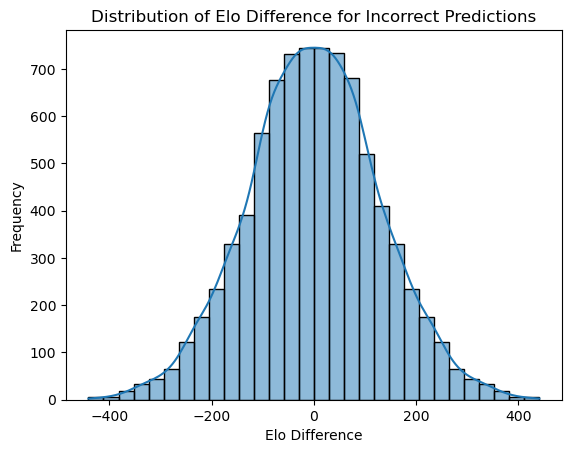

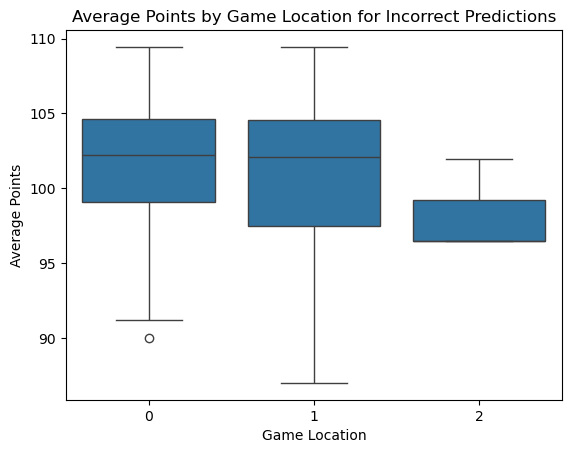

In [16]:
#just trying something out here...

import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the distribution of 'elo_diff' for incorrect predictions
sns.histplot(data=error_analysis, x='elo_diff', bins=30, kde=True)
plt.title('Distribution of Elo Difference for Incorrect Predictions')
plt.xlabel('Elo Difference')
plt.ylabel('Frequency')
plt.show()

# Example: Boxplot for 'avg_pts' to see if outliers influence errors
sns.boxplot(data=error_analysis, x='game_location', y='avg_pts')
plt.title('Average Points by Game Location for Incorrect Predictions')
plt.xlabel('Game Location')
plt.ylabel('Average Points')
plt.show()


              precision    recall  f1-score   support

           0       0.68      0.66      0.67     12632
           1       0.67      0.68      0.68     12631

    accuracy                           0.67     25263
   macro avg       0.67      0.67      0.67     25263
weighted avg       0.67      0.67      0.67     25263



<Axes: >

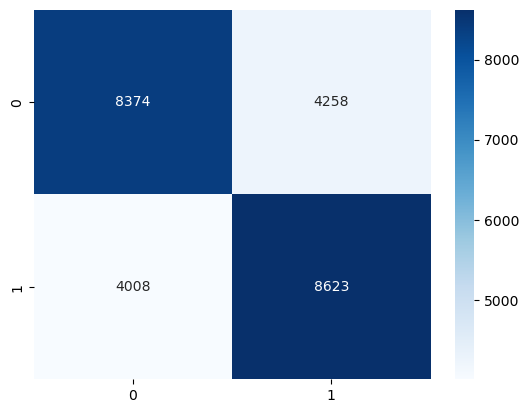

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")


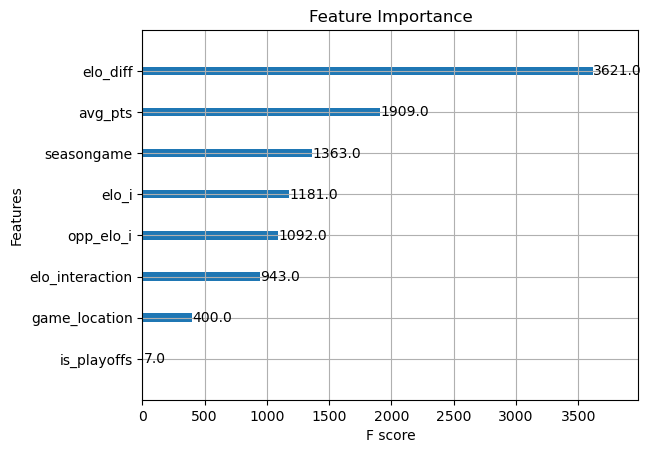

In [19]:
xgb.plot_importance(best_model)
plt.title("Feature Importance")
plt.show()
